# COGS 118B - Final Project

## Book Recommendation System

## Group members

- Natalia Abdulmawla
- Aarya Patel
- Brian Lee
- Holden Ly
- Yanxiong Chen

## Abstract

The goal of our project is to explore the book-crossing dataset and build a recommendation system for books based on the dataset. The dataset contains 8 different features with 1,149,780 ratings of 271,379 books measured on a scale of 1 to 10 by 278,858 people. To build the system we will be using methods such as k-means clustering and principal component analysis, finding what algorithms best work with our data, to find underlying patterns within the data allowing us to cluster the people and books based on the ratings and other features and using PCA to reduce the large dimensionality of the dataset and better visualize the clusters. Subsequently we will evaluate the performance of our recommendation system using metrics such as precision and recall. Through this project we aim to demonstrate how the books and given features can be used to provide personalized book recommendations based on a person's interests.

### Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

## Exploratory Data Analysis
### Reading Data


In [40]:
books = pd.read_csv("Books.csv", sep=";")
users = pd.read_csv("Users.csv", sep=";")
ratings = pd.read_csv("Ratings.csv", sep=";")

<ipython-input-40-361a5b60f0e0>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  users = pd.read_csv("Users.csv", sep=";")


In [41]:
display(books.head())
books.shape

,ISBN,Title,Author,Year,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


(271379, 5)

In [42]:
display(users.head())
users.shape

,User-ID,Age
0,1,NaN
1,2,18
2,3,NaN
3,4,17
4,5,NaN


(278859, 2)

In [43]:
display(ratings.head())
ratings.shape

,User-ID,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


(1149780, 3)

### Cleaning data

### Clean 'users' df

In [44]:
# Rename 'User-ID' to 'UserID'
users = users.rename(columns={'User-ID': 'UserID'})

In [45]:
# Convert 'Ages' to numeric
users['Age'] = pd.to_numeric(users['Age'], errors='coerce')

# Calculate the mean, median, and standard deviation
print("Mean Age: ", users['Age'].mean())
print("Median Age: ", users['Age'].median())
print("Standard Deviation of Age: ", users['Age'].std())

Mean Age:  34.72840724853575
Median Age:  32.0
Standard Deviation of Age:  14.408645139788613


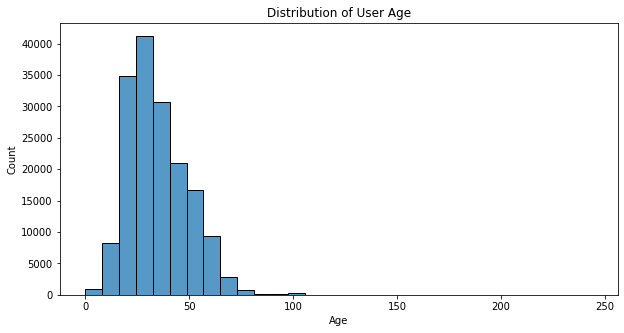

In [46]:
# Plot a histogram of 'Ages' to help understand the distribution of ages and find a logical age range 
plt.figure(figsize=(10,5))
sns.histplot(users['Age'], bins=30)
plt.title('Distribution of User Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Looking at the plot, a reasonable range should be from 5 to 85

In [47]:
# Clean 'Age' by removing and replacing NaN values and outliers such as < 5 and > 85 with the mean age
users.loc[(users.Age > 85) | (users.Age < 5), 'Age'] = np.nan
users['Age'] = users['Age'].fillna(users['Age'].mean())

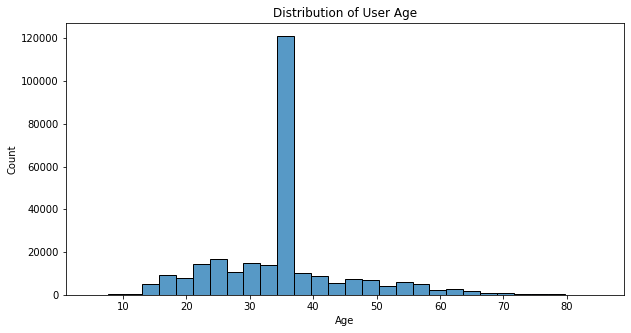

In [48]:
# Plot histogram of ages after cleaning values
plt.figure(figsize=(10,5))
sns.histplot(users['Age'], bins=30)
plt.title('Distribution of User Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### Clean 'ratings' df

In [49]:
# Rename 'User-ID' to 'UserID'
ratings = ratings.rename(columns={'User-ID': 'UserID'})

In [50]:
display(ratings.head())
print(ratings.shape)

,UserID,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


(1149780, 3)


In [51]:
# Filter 'ratings' df to only include rows where 'ISBN' is also found in the 'ISBN' in 'books' df
ratings = ratings[ratings.ISBN.isin(books.ISBN)]
print (ratings.shape)

(1031175, 3)


This will clean the dataset from any values which won't be of use for the recommendation system and speed up the algorithm by even the smallest bit.

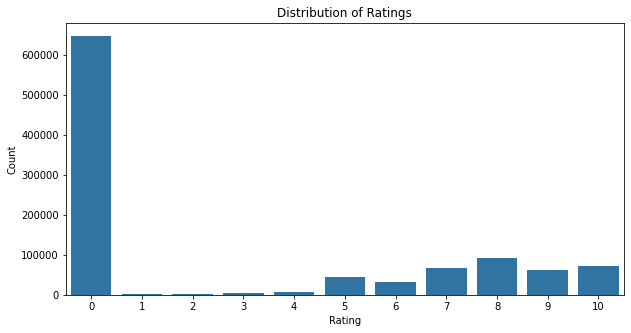

In [52]:
# Distribution of Ratings
plt.figure(figsize=(10,5))
sns.countplot(x='Rating', data=ratings)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Clean 'books' df

In [53]:
# Calculate mean rating and number of ratings for each book
book_ratings = ratings.groupby('ISBN')['Rating'].agg(['count', 'mean'])

# Rename the columns
book_ratings.rename(columns={'count': 'rating_count', 'mean': 'avg_rating'}, inplace=True)

# Merge this df with the 'books' DataFrame
books = books.merge(book_ratings, on='ISBN', how='left')

# Fill NaN values with 0
books[['avg_rating', 'rating_count']] = books[['avg_rating', 'rating_count']].fillna(0)

In [ ]:
books.loc[books["rating_count"] > 100].sort_values(by="avg_rating", ascending=False).head(10)

,ISBN,Title,Author,Year,Publisher,rating_count,avg_rating
5432,0439064864,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic,170.0,6.611765
5431,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,194.0,6.541237
3839,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,Scholastic,197.0,6.467005
2809,0590353403,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,1998,Scholastic,168.0,6.363095
5506,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic,334.0,5.571856
6330,0439136369,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2001,Scholastic,226.0,5.345133
2232,0812550706,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1994,Tor Books,195.0,5.302564
1150,0671027344,The Perks of Being a Wallflower,Stephen Chbosky,1999,MTV,103.0,5.194175
6933,0439139600,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2002,Scholastic Paperbacks,193.0,5.103627
3354,0345339681,The Hobbit : The Enchanting Prelude to The Lor...,J.R.R. TOLKIEN,1986,Del Rey,281.0,5.007117


In [ ]:
books.loc[books["rating_count"] > 100].sort_values(by="rating_count", ascending=False).head(10)

,ISBN,Title,Author,Year,Publisher,rating_count,avg_rating
26,0971880107,Wild Animus,Rich Shapero,2004,Too Far,2502.0,1.019584
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",1295.0,4.468726
748,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,883.0,4.652322
1105,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,732.0,3.448087
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,723.0,4.334716
305,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company,647.0,3.187017
356,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,615.0,4.219512
1922,067976402X,Snow Falling on Cedars,David Guterson,1995,Vintage Books USA,614.0,3.255700
118,0671027360,Angels & Demons,Dan Brown,2001,Pocket Star,586.0,3.718430
706,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books,585.0,4.105983


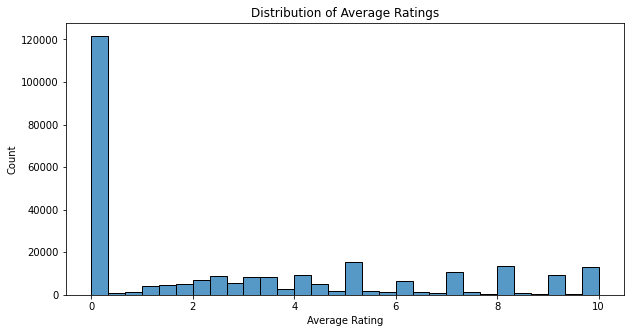

In [ ]:
# Plot a histogram of average ratings
plt.figure(figsize=(10,5))
sns.histplot(books['avg_rating'], bins=30)
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()


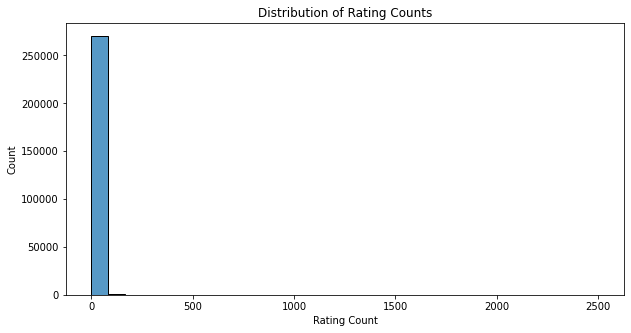

In [ ]:
# Plot a histogram of rating counts
plt.figure(figsize=(10,5))
sns.histplot(books['rating_count'], bins=30)
plt.title('Distribution of Rating Counts')
plt.xlabel('Rating Count')
plt.ylabel('Count')
plt.show()


## Data preprocessing

In [ ]:
# Get the ISBNs of books with more than 50 ratings
isbn_rating_count = books[books["rating_count"] > 50]["ISBN"]

# Filter the 'ratings' df to include only these ISBNs
filtered_ratings = ratings[ratings["ISBN"].isin(isbn_rating_count)]

# Drop duplicates
book_matrix = filtered_ratings.drop_duplicates()

# Display the new df
print(book_matrix)


         UserID        ISBN  Rating
0        276725  034545104X       0
2        276727  0446520802       0
8        276744  038550120X       7
10       276746  0425115801       0
11       276746  0449006522       0
...         ...         ...     ...
1149761  276704  0345386108       6
1149767  276704  0446353957       0
1149768  276704  0446605409       0
1149771  276704  0743211383       7
1149772  276704  080410526X       0

[231876 rows x 3 columns]
